In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import doctest
import copy

In [ ]:
#https://stackoverflow.com/questions/40137950/possible-to-run-python-doctest-on-a-jupyter-cell-function
def test(func):
    '''
    Use test as a decorator to a function with doctests in Jupyter notebook. 
    Run the cell to see the results of the doctests.
    '''
    globs = copy.copy(globals())
    globs.update({func.__name__:func})
    doctest.run_docstring_examples(func, globs, verbose=True, name=func.__name__)
    return func

### Simulate straight line and circular movements with Unicycle model

Robot is at the origin (0, 0) and facing North, i.e, $\theta = \pi/2$

Use the Kinematics equations we had developed in class for the Unicycle model

In [ ]:
@test 
def unicycle_model(curr_pose, v, w, dt=1.0):
    '''
    >>> unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
    (1.0, 0.0, 0.0)
    >>> unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
    (0.0, 0.0, 1.0)
    >>> unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
    (1.0, 0.0, 1.0)
    '''
    ## write code to calculate next_pose
    # refer to the kinematic equations of a unicycle model
    x, y, theta = curr_pose
    x += v*np.cos(theta)*dt
    y += v*np.sin(theta)*dt
    theta += w*dt
    
    # Keep theta bounded between [-pi, pi]
    theta = np.arctan2(np.sin(theta), np.cos(theta))

    # return calculated (x, y, theta)
    return x, y, theta


PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.7/doctest.py", line 1487, in run
    sys.settrace(save_trace)



Finding tests in unicycle_model
Trying:
    unicycle_model((0.0,0.0,0.0), 1.0, 0.0)
Expecting:
    (1.0, 0.0, 0.0)
ok
Trying:
    unicycle_model((0.0,0.0,0.0), 0.0, 1.0)
Expecting:
    (0.0, 0.0, 1.0)
ok
Trying:
    unicycle_model((0.0, 0.0, 0.0), 1.0, 1.0)
Expecting:
    (1.0, 0.0, 1.0)
ok


Now let us try to simulate motion along a straight line and circle

Look at the kinematics equations you wrote - what should $v,\omega$ if
+ There is no change in $\theta$
+ $\theta$ has to change from 0 to 360 degrees

In [ ]:
#straight line
straight_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values
all_v = np.ones(steps)
all_w = np.zeros(steps)
for v, w in zip(all_v, all_w):
   # store pose
   straight_trajectory.append(pose)
   #instruction to take v, w and compute new pose    
   pose = unicycle_model(pose, v, w)
straight_trajectory = np.array(straight_trajectory)
    

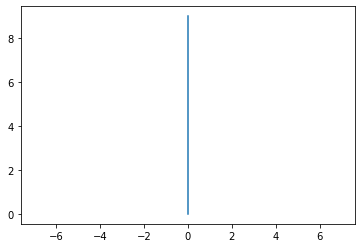

In [ ]:
## plot for straight line
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(straight_trajectory[:,0], straight_trajectory[:,1])
plt.show()

In [ ]:
#circular trajectory
circular_trajectory = []
pose = (0, 0, np.pi/2)
steps = 10
#fill in v and omega values
all_v = np.ones(steps*10)
all_w = np.ones(steps*10)
for v, w in zip(all_v, all_w):
   # store pose
   circular_trajectory.append(pose)
   #instruction to take v, w and compute new pose    
   pose = unicycle_model(pose, v, w,0.1)
circular_trajectory = np.array(circular_trajectory)
    

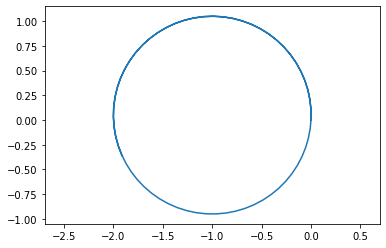

In [ ]:
### Plot for circular trajectories
plt.figure()
plt.axes().set_aspect("equal","datalim")
plt.plot(circular_trajectory[:,0], circular_trajectory[:,1])
plt.show()

### Simulate Unicycle model with Open Loop control

We want the robot to follow these instructions

**straight 10m, right turn, straight 5m, left turn, straight 8m, right turn**

It is in open loop; control commands have to be calculated upfront. How do we do it?

To keep things simple in the first iteration, we can fix $v = v_c$ and change only $\omega$. To make it even simpler, $\omega$ can take only 2 values 
+ 0 when the vehicle is going straight 
+ $\omega = \omega_c$ when turning

This leaves only 2 questions to be answered
* What should be $v_c$ and $\omega_c$?
* When should $\omega$ change from 0 and back?

In [ ]:
vc = 1 #m/s
wc = np.pi/6 #rad/s

#calculate time taken to finish a quarter turn (pi/2)
t_turn = int(np.pi/2/wc)

#calculate the time taken to finish straight segments
# omega array is to be padded with equivalent zeros

t_straight1, t_straight2, t_straight3 = int(10/vc), int(5/vc), int(8/ vc)

all_w = [0]*t_straight1 + [wc]*t_turn + \
        [0]*t_straight2 + [wc]*t_turn + \
        [0]*t_straight3 + [-wc]*t_turn

all_v = vc*np.ones_like(all_w)

Let us make a cool function out of this!

Take in as input a generic route and convert it into open-loop commands

Input format: [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]

Output: all_v, all_w

In [ ]:
def get_open_loop_commands(route, vc_slow=0.5,vc_fast=1.0, wc=np.pi/12, dt=1.0):
    all_w = []
    omegas = {'straight': 0, 'left': wc, 'right': -wc} 
    for manoeuvre, command in route:
      u = np.ceil(command/vc).astype('int')
      v = np.ceil(np.deg2rad(command)/wc).astype('int')
      t_cmd = u if manoeuvre == 'straight' else v
      all_w += [omegas[manoeuvre]]*t_cmd
    all_v = vc*np.ones_like(all_w)
    return all_v, all_w

### Unit test your function with the following inputs

+ [("straight", 5), ("right", 90), ("straight", 6), ("left", 85)]
+ $v_c = 1$
+ $w_c = \pi/12$

In [ ]:
all_v, all_w = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)])

In [ ]:
robot_trajectory = []
all_v, all_w = get_open_loop_commands([("straight", 5), ("right", 90), ("straight", 6), ("left", 85)])
pose = np.array([0, 0, np.pi/2])
for v, w in zip(all_v, all_w): 
      robot_trajectory.append(pose)
      pose = unicycle_model(pose, v, w)
robot_trajectory = np.array(robot_trajectory)

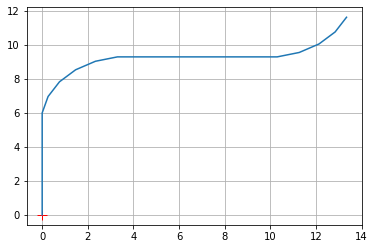

In [ ]:
# plot robot trajectory
plt.figure()
plt.grid()
#plt.plot( )

#show first and last robot positions with + markers
xi, yi, _ = robot_trajectory[0]
xf, yf, _ = robot_trajectory[-1]
plt.plot(xi,yi,'r+',ms=10)
plt.plot(robot_trajectory[:,0], robot_trajectory[:,1])
plt.show()

### Improved capabilities!

+ Slow the robot while turning ($v_c$ for turn and straight needed)

+ How to accommodate a sampling time < 1.0s (hint: think of sampling instances instead of time)